In [ ]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

import os, shutil, pathlib, glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import random
SEED = 3322
random.seed(SEED)

We are uploading the kaggle json file to faciliate the process of obtaining the dataset of histopathological images

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bluekingnfx","key":"38179171ad0688082f225c9624c71335"}'}

Initializing Kaggle directory in google collab and moving the json into the kaggle folder to install dataset

In [ ]:
#Create "~/.kaggle" directory
!mkdir ~/.kaggle

#Move "kaggle.json" file to this directory
!mv kaggle.json ~/.kaggle/

Giving the write access to the folder created in linux os of google collab hosted in cloud

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset with API command

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:37<00:00, 25.2MB/s]
100% 3.10G/3.10G [00:37<00:00, 89.6MB/s]


Create a directory "dataset" to unzip the file there

In [ ]:
!mkdir dataset
!ls

breast-histopathology-images.zip  dataset  sample_data


Unziping the dataset

In [ ]:
!unzip -qq "/content/breast-histopathology-images.zip" -d "/content/dataset"

Total directories (that is, total number of patients)

In [ ]:
dirs = os.listdir("/content/dataset/")
print("Total number of directories are =",len(dirs))

Total number of directories are = 280


The dataset assigns a unique filename structure to each image, like:
```
u_xX_yY_classC.png

```
For example:
```
10253_idx5_x1351_y1101_class0.png
```

- "u" is patient id
- "u" is the patient ID (10253_idx5),
- "X" is the x-coordinate of where this patch was cropped from,
- "Y" is the y-coordinate of where this patch was cropped from, and
- "C" indicates the class where 0 is non-IDC and 1 is IDC.

In [ ]:

def plot_random_patches(clas):
    fig, axes = plt.subplots(7,7,figsize=(10,10))
    for ax in axes.flatten():
        #Get a random patient id
        patient_id = random.choice(dirs)

        path = f"/content/dataset/{patient_id}/{clas}/*.png"
        #Read all the files' path present in "path" directory
        paths = glob.glob(path)
        #Select a random file path
        p = random.choice(paths)
        #Get the path with semantics appropriate for underlying OS
        p = pathlib.Path(p)
        #Load the image
        img = load_img(p)
        #Plot theimage
        ax.imshow(img)
        #Set image properties
        ax.set_title(label=patient_id, fontdict={"fontsize":8})
        ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

    #Use different image title for cancer and normal tissues
    if clas == 1:
        fig.suptitle('IDC+ patches\n(Cancer tissues)', fontsize=16)
    else:
        fig.suptitle('IDC- patches\n(Noraml tissues)', fontsize=16)

Plot random images of IDC+ / cancer tissues

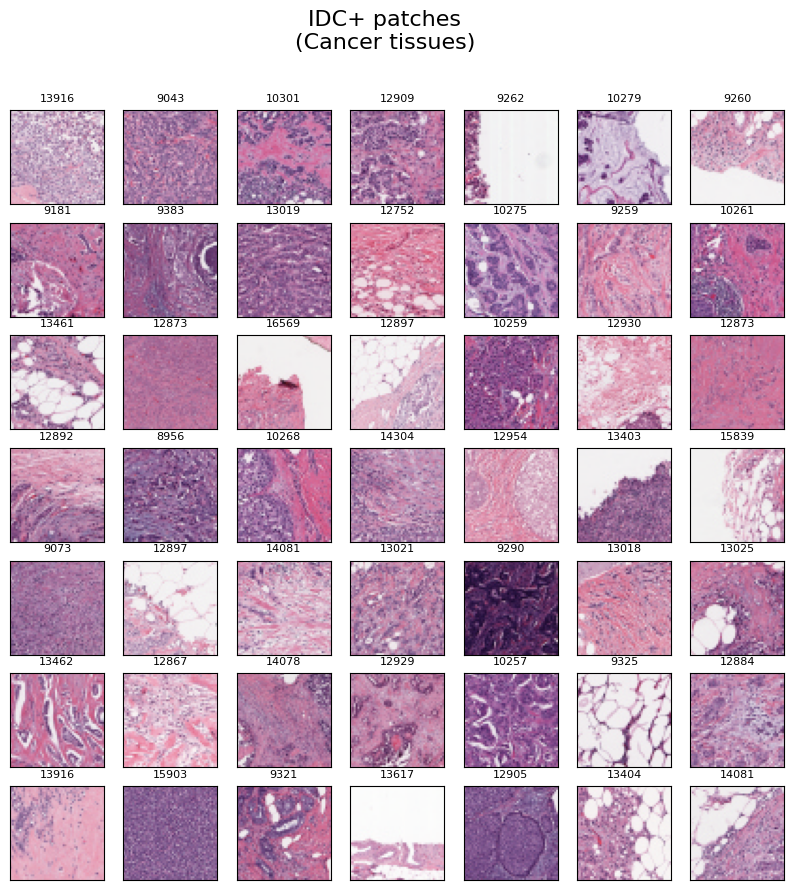

In [ ]:

plot_random_patches(clas=1)

In [ ]:
"""
The core functionality: For each paitent (directory)
thier corresponding 0 and 1 samples are seggregated and randomized,
then the classes for each iteration is extended to main arrays of class_0, class_1
This function is built to improve random sampling.
"""

def get_image_path_list():
    #Create empty lists to store the paths of class 0 and class 1 images
    class_0 = []
    class_1 = []
    for dir in dirs:
        #Read class 0 and class 1 images' paths for a given patient
        # and store them it their respective list
        c_0 = glob.glob(f"/content/dataset/{dir}/0/*.png")
        c_1 = glob.glob(f"/content/dataset/{dir}/1/*.png")

        random.shuffle(c_0)
        random.shuffle(c_1)

        #Add the class 0 and class 1 images' paths for a given patient
        # to the main list
        class_0.extend(c_0)
        class_1.extend(c_1)

        random.shuffle(class_0)
        random.shuffle(class_1)

    #Shuffle the paths lists randomly
    random.shuffle(class_0), random.shuffle(class_0)
    random.shuffle(class_1), random.shuffle(class_1)

    #Return the class_0 and class_1 lists
    return class_0, class_1

In [ ]:
'''
Core functionality is to create a train and test directory under the new_dataset main directory,
the seggregation of the image files of specific class is defined by specific threshold value,
default in create_dataset function, about 80% of data is used for training.

'''

def create_dataset(train_split=0.80):

    train0_dir = "/content/new_dataset/train/0"
    train1_dir = "/content/new_dataset/train/1"
    os.makedirs(train0_dir)
    os.mkdir(train1_dir)

    test0_dir = "/content/new_dataset/test/0"
    test1_dir = "/content/new_dataset/test/1"
    os.makedirs(test0_dir)
    os.mkdir(test1_dir)

    class0, class1 = get_image_path_list()

    random.shuffle(class0)
    random.shuffle(class1)

    total_img0 = len(class0)
    total_img1 = len(class1)

    train0_thresh = int(total_img0 * train_split)
    train1_thresh = int(total_img1 * train_split)

    for i in range(total_img0):
        path = class0[i]
        if i < train0_thresh:
            shutil.copy(src=path, dst= train0_dir)
        else:
            shutil.copy(src=path, dst= test0_dir)

    for i in range(total_img1):
        path = class1[i]
        if i < train1_thresh:
            shutil.copy(src=path, dst= train1_dir)
        else:
            shutil.copy(src=path, dst= test1_dir)

In [ ]:
create_dataset()

Checkpoint: We new_dataset directory of structure train and test sub directory, this indeed contains 0 and 1 directory of 0 and 1 images. Train: 80% data, test: 20%.

In [ ]:
class0, class1 = get_image_path_list()

print("80% images of class 0 =", int(len(class0)*0.80))
print("80% images in class 1 =", int(len(class1)*0.80))

train_data_size = glob.glob("/content/new_dataset/train/**/*.png")
print("Training dataset size =",len(train_data_size))

80% images of class 0 = 158990
80% images in class 1 = 63028
Training dataset size = 222018


Image_dataset_from directory helps to create a image dataset from class labels infered from the subdirectories, image_size is resized to 50x50 and 32 images are processed once.

Subnet argument in validation_dataset is used to return all the images that were ommited in training dataset to validation dataset

In [ ]:
image_size = (50,50)
batch_size = 32
train_dataset = image_dataset_from_directory(
    "/content/new_dataset/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)


validation_dataset =image_dataset_from_directory(
    "/content/new_dataset/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 222018 files belonging to 2 classes.
Using 177615 files for training.
Found 222018 files belonging to 2 classes.
Using 44403 files for validation.


Same process is carried for testing dataset without subnetting

In [ ]:
test_dataset = image_dataset_from_directory(
    "/content/new_dataset/test",
    labels = "inferred",
    label_mode = 'int',
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 55506 files belonging to 2 classes.


Since neural networks should consume lot of images to cover up/recoginize, since over dataset of training is just 2 lakhs+ it is minimal, this tend to make the model more or less overfit, to overcome this, we going to use data augmentation and dropout layer techniques.

Data agumentation - Is the process of creating additional images by resizing and magnizing the already existing images, there by increasing the size of the exisiting dataset

Dropout layer - Disabling certain nodal layers to combat the team effect, putting more burdern certain layers to have a significant effect.

For modeling, the keras sequential architure is utilized, Pulling in layers required to form a neural network of own.

Combat overfitting

In [ ]:
inputs = keras.Input(shape=(50, 50, 3))
x = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3)
    ]
)(inputs)
x = layers.Rescaling(1./255)(x)

Conventions
- Going to use the generally used architecture,
Convultional neural layer -> Batch normalization -> Activation -> pooling

Neural set to identify of 256 filters/features initally, larger number because smaller dimension of the image.
Batch normalization, normalizing the input and activating the nodes

Pooling -> Amplifing the patterns/features

Three layers same process flow to improve better recoginization. Only 3 cause of computational cost







In [ ]:
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

Flatting the multi-dimension vector to single dimensional, passed to dense layer (fully connected NN) and to the output layer assigns 0 or 1

In [ ]:
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)


Connecting to input and output layer

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 256)         │           6,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,947,969 (15.06 MB)

 Trainable params: 3,945,921 (15.05 MB)

 Non-trainable params: 2,048 (8.00 KB)

input_2: The input image layer taking images of shape (50, 50, 3)

sequential_1: Empty sequential model, does nothing
rescaling_1: Rescales input pixels from 0-255 to 0-1.

conv2d_4: 2D Convolution layer with 256 filters of kernel size 3

batch_normalization_4: Normalizes activations from conv layer

activation_4: ReLU activation function

conv2d_5, batch_normalization_5 etc: Repeats convolution, batch norm, activation blocks.

max_pooling2d_3: Max pooling to downsample spatially by half.

flatten_1: Flattens final conv feature maps to 1D vector

dropout_1: Applies dropout regularization

dense_4, dense_5 etc: Fully connected layers outputting class predictions.

Total number of edges in the neural network are about 39lakhish and on - trainable params are of 2048 contributed by normalization layers.

Compiling before training,

Telling model what things must be used,

loss function is to binary_crossentropy -> assigning 0 or 1
optimizer - Update weights during training

metrices - To been considered while training

In [ ]:
model.compile(loss="binary_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

Stopping condition when to save the model


In [ ]:
callbacks = [
            keras.callbacks.ModelCheckpoint(filepath="model.keras",
                                            save_best_only=True,
                                            monitor="val_loss")
            ]

Training the model

In [ ]:
fit_model = model.fit(
                    train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks
                   )

Epoch 1/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 426s 75ms/step - accuracy: 0.8347 - loss: 0.3960 - val_accuracy: 0.8574 - val_loss: 0.3532
Epoch 2/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 439s 76ms/step - accuracy: 0.8549 - loss: 0.3428 - val_accuracy: 0.8248 - val_loss: 0.3971
Epoch 3/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 462s 79ms/step - accuracy: 0.8588 - loss: 0.3389 - val_accuracy: 0.8462 - val_loss: 0.3844
Epoch 4/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 425s 76ms/step - accuracy: 0.8591 - loss: 0.3382 - val_accuracy: 0.8509 - val_loss: 0.3492
Epoch 5/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 422s 76ms/step - accuracy: 0.8642 - loss: 0.3280 - val_accuracy: 0.8189 - val_loss: 0.4296
Epoch 6/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 443s 76ms/step - accuracy: 0.8657 - loss: 0.3256 - val_accuracy: 0.8562 - val_loss: 0.3403
Epoch 7/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 444s 77ms/step - accuracy: 0.8672 - loss: 0.3194 - val_accuracy: 0.7613 - val_loss: 0.5070
Epoch 8/10
5551/5551 ━━━━━━━━━━━━━━━━━━━━ 460s 80ms/step - accuracy: 


## CONCLUSION 1

### 1. The training set accuracy of **87%** at the end of 10 epochs is observed.
### 2. **On average 80% of validation set variance is been explained by the model**, in core essense the model can be trustable.


In [ ]:
test_model = keras.models.load_model("/content/model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.8733 - loss: 0.3004
Test accuracy: 0.875


## CONCLUSION 2:

### The accuracy over testing test is 0.875, which means that model has able to **compentently** eligible for an business pontential patronized by the fact has it able to explain the 87.5% of testing set or **unseen data**.


*This outcome is particularly impressive considering the small size of the dataset and the fact that the image patches were only 50x50 pixels, and the model was trained from scratch.*


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model("/content/model.keras")

In [ ]:
import tensorflow as tf

Load the image by given path to the target size of 50X50

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/Sample_image_for_testing_class1.png', target_size=(50, 50))

Normalize the pigment color of RGB in the range of 0 to 1

In [ ]:
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

Expanding the dimensions to model expectance

In [ ]:
img_array = np.expand_dims(img_array, axis=0)

Sample Predicition

In [ ]:
img_array

In [ ]:
prediction = model.predict(img_array)
prediction

In [ ]:
original_model = load_model("/content/original_model.keras")

In [ ]:
def predict_output(path):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(50, 50))
  img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  prediction = original_model.predict(img_array,batch_size=100,)
  return prediction


In [ ]:
predict_output("/content/breastmalignantductalNOSJorns21.jpg")

In [ ]:
predict_output("/content/Sample_image_for_testing_class1.png")

In [ ]:


import streamlit as st

# Create a file uploader widget
uploaded_file = st.file_uploader("Choose an image file")

if uploaded_file is not None:
  img = tf.keras.preprocessing.image.load_img(uploaded_file, target_size=(50, 50))
  img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  prediction = original_model.predict(img_array,batch_size=100,)
  print(prediction)




In [ ]:
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)

#@st.cache(allow_output_mutation=True)
def load_model():
  model = tf.keras.models.load_model('/content/original_model.keras')
  return model

model = load_model()

st.title('Image Classification')

uploaded_file = st.file_uploader("Choose an image", type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:

  img = Image.open(uploaded_file)
  img = tf.keras.preprocessing.image.load_img(uploaded_file, target_size=(50, 50))
  img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  prediction = model.predict(img_array,batch_size=100,)
  print(prediction)

if __name__ == '__main__':
  st.markdown('''Streamlit app to classify images using a Keras
               model. Upload an image to get started.''')

In [ ]:
pwd

In [ ]:
!streamlit run "/content/file.py"

In [ ]:
!pip install ipystreamlit